Let's load the datasets prepared in Part 1:

In [41]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
train_from_part_1 = pd.read_csv('new_datasets/train_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_1 = pd.read_csv('new_datasets/test_from_part_1.csv', index_col='ID_LAT_LON_YEAR_WEEK')

train_from_part_1['date'] = pd.to_datetime(train_from_part_1['date'])
test_from_part_1['date'] = pd.to_datetime(test_from_part_1['date'])

top_three_values = train_from_part_1.loc[:, 'Location_enc'].drop_duplicates().sort_values(ascending = False).head(3)
top_three_locations = train_from_part_1.loc[train_from_part_1['Location_enc'].isin(top_three_values), 'Location'].drop_duplicates()


CPU times: total: 1.06 s
Wall time: 1.1 s


In this part we'll work with the 'emission' time series, calculating trend, seasonality, cycles, etc. Therefore, we need a new method for comparing performances of our models.

We'll separate our training set from part 1 on a training and cross-validation set. Cross-validation set will include several last observations from all the Locations.

In testing a new feature, we'll first calculate this feature on a training set, then predict it on a cross-validation set and calculate cross-validation RMSE. 

If we see improvements (Cross-val RMSE goes down), then we keep the new feature.

For the submission, we'll recalculate the new feature on the whole training set and predict on the test set.

Let's divide the training set from the part 1:

In [42]:
# Calculate the proportion of test set weeks compared to the total number of weeks
proportion = len(test_from_part_1) / (len(train_from_part_1) + len(test_from_part_1))

# Calculate the desired amount of weeks in the cross-validation set
train_from_part_1_weeks = len(train_from_part_1['WeekCount'].unique())
cv_weeks = round(train_from_part_1_weeks * proportion)
train_weeks = train_from_part_1_weeks - cv_weeks
test_weeks = len(test_from_part_1['WeekCount'].unique())

print('Weeks in the training set: {}'.format(train_weeks))
print('Weeks in the cross-validation set: {}'.format(cv_weeks))
print('Weeks in the test set: {}'.format(test_weeks))

# Create training and cross-validation sets
train = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] < train_weeks, ['Location', 'WeekCount', 'date', 'emission']])
cv = pd.DataFrame(train_from_part_1.loc[train_from_part_1['WeekCount'] >= train_weeks, ['Location', 'WeekCount', 'date', 'emission']])


print("The last 5 rows of the cross-validation set:")

cv.tail()

Weeks in the training set: 122
Weeks in the cross-validation set: 37
Weeks in the test set: 49
The last 5 rows of the cross-validation set:


,Location,WeekCount,date,emission
ID_LAT_LON_YEAR_WEEK,,,,
ID_-3.299_30.301_2021_48,-3.29930.301,154,2021-12-03,29.404171
ID_-3.299_30.301_2021_49,-3.29930.301,155,2021-12-10,29.186497
ID_-3.299_30.301_2021_50,-3.29930.301,156,2021-12-17,29.131205
ID_-3.299_30.301_2021_51,-3.29930.301,157,2021-12-24,28.125792
ID_-3.299_30.301_2021_52,-3.29930.301,158,2021-12-31,27.239302


## 00. Baseline

We'll use a separate scores DataFrame in this part, with RMSE as our scores. Let's calculate a new baseline, where emissions will be just the median emissions (calculated on the training set):

In [43]:
study_number = '00'

from sklearn.metrics import mean_squared_error


# Calculate train and cv RMSE
score_train = mean_squared_error(train['emission'], [train['emission'].median()] * len(train), squared=False)
score_cv = mean_squared_error(cv['emission'], [train['emission'].median()] * len(cv), squared=False)

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': [train_from_part_1['emission'].median()] * len(test_from_part_1)})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)


In [44]:
# Create scores DataFrame
scores_df = pd.DataFrame({'Comment': [], 'Train RMSE': [], 'Cross-val RMSE': [], 'Test RMSE': []})

# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Just Median'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = 175.20974

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.13248,175.20974


## Exploring time series

Let's look at the 'emission' time series for every location that has median emissions above 95th quantile:

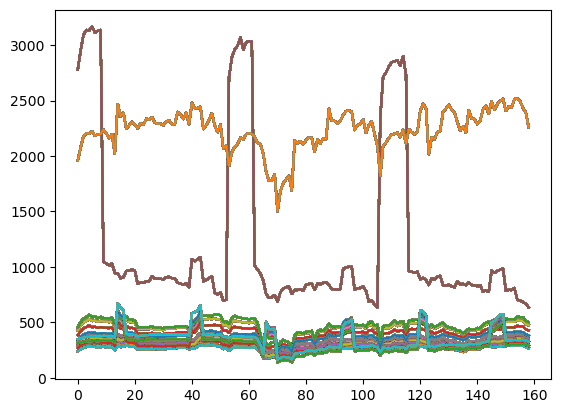

CPU times: total: 14 s
Wall time: 14.7 s


In [45]:
%%time

quantile = train_from_part_1['emission'].quantile(0.95)

import matplotlib.pyplot as plt

for location in train_from_part_1.loc[train_from_part_1['Location_enc'] > quantile, 'Location']:
    series = train_from_part_1.loc[train_from_part_1['Location'] == location, 'emission']
    plt.plot(range(len(series)), series)
plt.show()

We can see a few things here:

-) There seems to be a common trend

-) Sesonality is similar for most of the locations, except for the two with the highest emissions.

## 01. Common trend

Let's look at the median emissions time series across all locations:

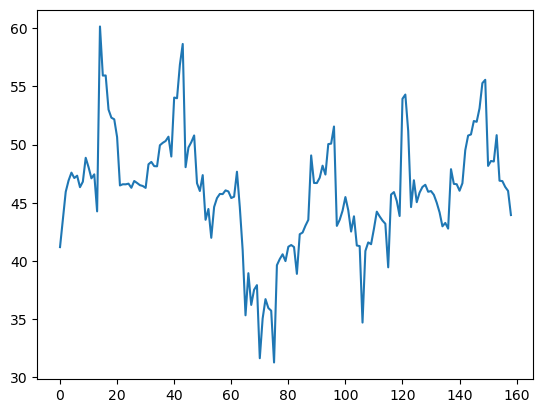

In [46]:
study_number = '01'

plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median())
plt.show()

Let's calculate a common trend on the traning set:

In [47]:
%%time

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Calculate trend on the training set
dp = DeterministicProcess(index=range(train_weeks), constant=True, order=2, drop=True)
X = dp.in_sample()
y = train.groupby('WeekCount')['emission'].median()

lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

y_train_pred = pd.Series(lr.predict(X), index=X.index)

train['CommonTrend'] = train['WeekCount'].map(y_train_pred)

# Continue trend on the cv set:

X = dp.out_of_sample(steps=49)

y_cv_pred = pd.Series(lr.predict(X), index=X.index)

cv['CommonTrend'] = cv['WeekCount'].map(y_cv_pred)

CPU times: total: 0 ns
Wall time: 13 ms


Let's look at the trend:

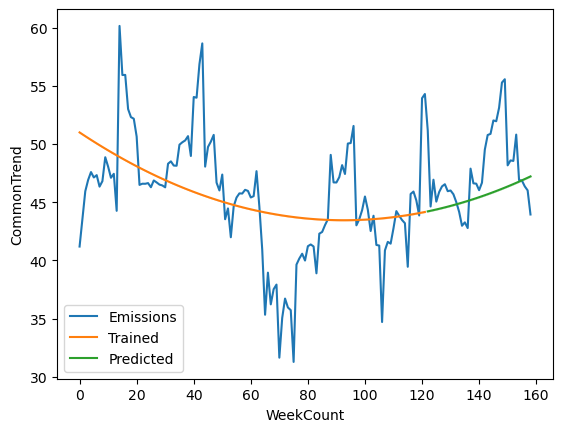

CPU times: total: 4.52 s
Wall time: 4.12 s


In [48]:
%%time

import seaborn as sns
ax = plt.plot(range(train_from_part_1_weeks), train_from_part_1.groupby('WeekCount')['emission'].median(), label='Emissions')
sns.lineplot(data = train, x='WeekCount', y='CommonTrend', label='Trained')
sns.lineplot(data = cv, x='WeekCount', y='CommonTrend', label='Predicted')
plt.legend()

plt.show()

Let's calculate the errors:

In [49]:
# Calculate scores
score_train = mean_squared_error(train['emission'], train['CommonTrend'], squared=False)
score_cv = mean_squared_error(cv['emission'], cv['CommonTrend'], squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'CommonTrend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN


Cross-val RMSE has decreased a bit, but not much. For simplicity, I suggest to not use the common trend.

## 02. Trend

Let's calculate a trend for each location. As we could see in the first plot in this notebook, there is one special location, that has a linear trend. We'll calulcate the trend for this location separately. For all the others we'll use a quadratic trend.

In [50]:
%%time

study_number = '02'

special_location = top_three_locations[1]

from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

for location in train['Location'].unique():
    # Create time series
    series = pd.Series(train.loc[train['Location'] == location, 'emission'].values, \
                   index=train.loc[train['Location'] == location, 'date'])
    series.index = series.index.to_period('W')
    #Save indices
    old_train_index = train[train['Location'] == location].index
    old_cv_index = cv[cv['Location'] == location].index
    
    ## Calculate trend on the training set
    
    order = 2
    # For the special location - linear trend
    if location == special_location:
        order = 1
    
    
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)

    y_pred = pd.Series(lr.predict(X), index=old_train_index)
    
    train.loc[old_train_index, 'Trend'] = y_pred
    
    # Continue trend on the cv set:
    X = dp.out_of_sample(steps=cv_weeks)
    
    y_pred = pd.Series(lr.predict(X), index=old_cv_index)
    
    cv.loc[old_cv_index, 'Trend'] = y_pred



CPU times: total: 38.8 s
Wall time: 9.4 s


Let's look at the trend example for the 3 Locations with the highest median emissions:

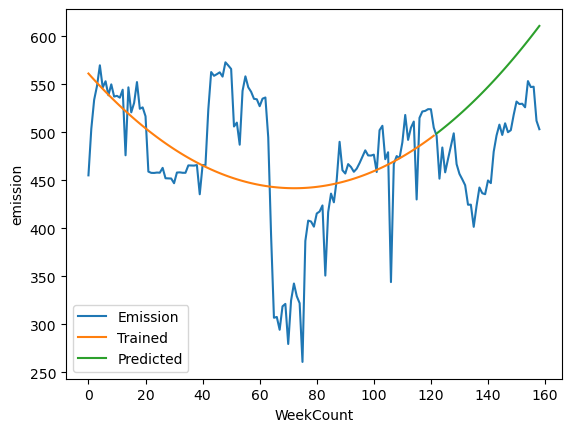

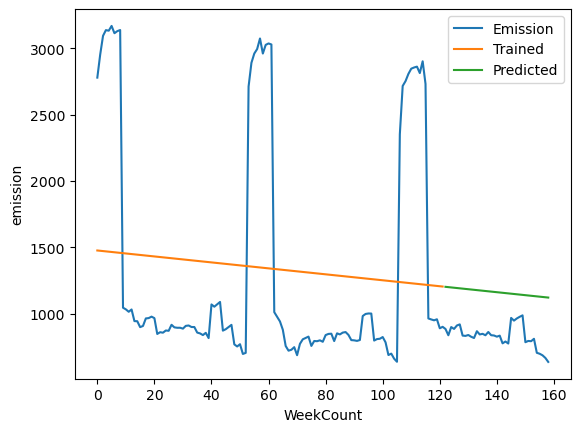

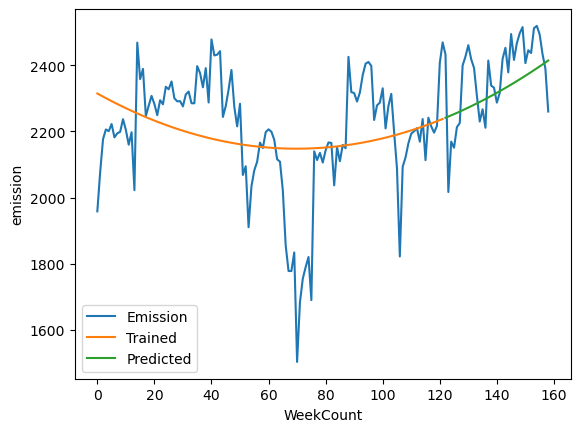

CPU times: total: 1.11 s
Wall time: 606 ms


In [51]:
%%time

for location in top_three_locations:

    sns.lineplot(data = train_from_part_1[train_from_part_1['Location'] == location], x='WeekCount', y='emission', label='Emission')
    sns.lineplot(data = train[train['Location'] == location], x='WeekCount', y='Trend', label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Trend', label='Predicted')
    plt.legend()
    plt.show()


Let's calculate the errors:

In [52]:
# Calculate scores
score_train = mean_squared_error(train['emission'], train['Trend'], squared=False)
score_cv = mean_squared_error(cv['emission'], cv['Trend'], squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = 'Trend'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN


Good, that worked. Now we have to do the following steps:

-) Recalculate trends on the whole available data

-) Predict for the test set

-) (optional) Make a submission and look at the Test RMSE

-) Create a new feature, 'emission_02' (where 02 is the current chapter number, not the part number). This feature will be equal to 'emission' - 'Trend', i.e, detrended 'emission', and in the next step we'll be using this feature as our new target.

Let's start:

In [53]:
%%time

# Prepare a new test DataFrame with new features
test = pd.DataFrame(test_from_part_1.loc[:, ['Location', 'WeekCount', 'date']])


# Recalculate trends on the whole available data
for location in train['Location'].unique():
    # Create time series
    series = pd.Series(train_from_part_1.loc[train_from_part_1['Location'] == location, 'emission'].values, \
                   index=train_from_part_1.loc[train_from_part_1['Location'] == location, 'date'])
    series.index = series.index.to_period('W')
    #Save indices
    old_train_index = train_from_part_1[train_from_part_1['Location'] == location].index
    old_test_index = test[test['Location'] == location].index
    
    order = 2
    
    # For the special location - linear trend
    if location == special_location:
        order = 1
    
    dp = DeterministicProcess(index=series.index, constant=True, order=order, drop=True)
    X = dp.in_sample()

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    
    y_pred = pd.Series(lr.predict(X), index=old_train_index)
    
    # Break the calculated trend on a train and cv parts
    y_pred_train = y_pred[: train_weeks]
    y_pred_cv = y_pred[train_weeks: ]
    
    train.loc[y_pred_train.index, 'Trend'] = y_pred_train
    cv.loc[y_pred_cv.index, 'Trend'] = y_pred_cv
    
    # Continue trend on the test set:
    
    X = dp.out_of_sample(steps=test_weeks)
    
    y_pred = pd.Series(lr.predict(X), index=old_test_index)
    
    test.loc[old_test_index, 'Trend'] = y_pred

CPU times: total: 48.4 s
Wall time: 11.1 s


Let's look at the trend examples for our top three Locations:

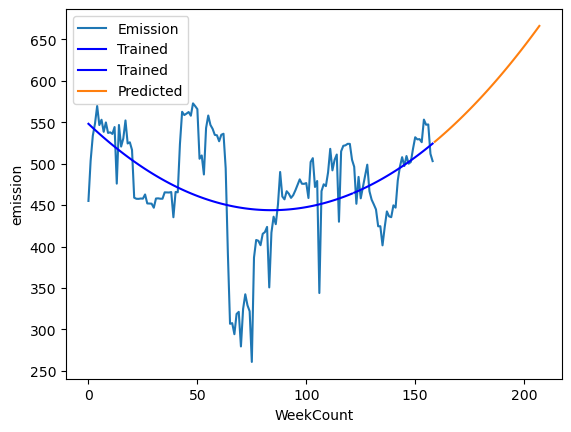

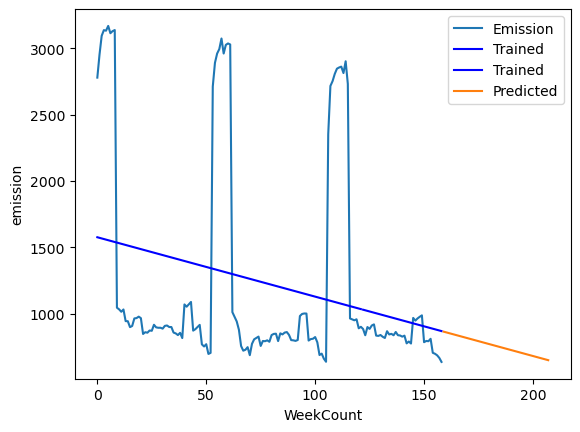

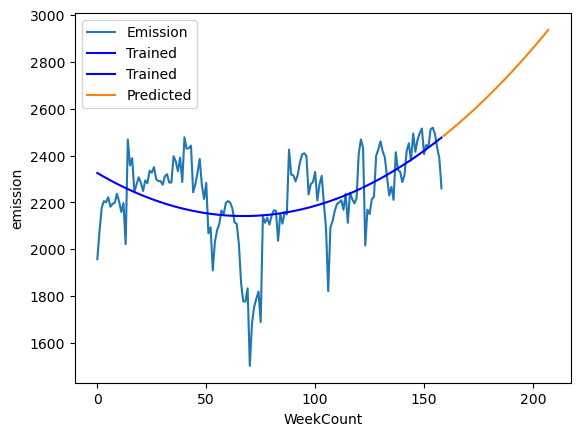

CPU times: total: 1.03 s
Wall time: 597 ms


In [54]:
%%time

for location in top_three_locations:

    sns.lineplot(data = train_from_part_1[train_from_part_1['Location'] == location], x='WeekCount', y='emission', label='Emission')
    sns.lineplot(data = train[train['Location'] == location], x='WeekCount', y='Trend', label='Trained', c='b')
    sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Trend', label='Trained', c='b')
    sns.lineplot(data = test[test['Location'] == location], x='WeekCount', y='Trend', label='Predicted')
    plt.legend()
    plt.show()



Let's make a submission and look at the Test RMSE:

In [55]:
# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': test['Trend']})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [56]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN


Let's create the detrended feature:

In [57]:
for data in [train, cv]:
    data['emission_' + study_number] = data['emission'] - data['Trend']
    
train.head()

,Location,WeekCount,date,emission,CommonTrend,Trend,emission_02
ID_LAT_LON_YEAR_WEEK,,,,,,,
ID_-0.510_29.290_2019_00,-0.5129.29,0,2019-01-01,3.750994,50.995863,4.527272,-0.776278
ID_-0.510_29.290_2019_01,-0.5129.29,1,2019-01-08,4.025176,50.833865,4.515137,-0.489960
ID_-0.510_29.290_2019_02,-0.5129.29,2,2019-01-15,4.231381,50.673625,4.503172,-0.271791
ID_-0.510_29.290_2019_03,-0.5129.29,3,2019-01-22,4.305286,50.515145,4.491378,-0.186092
ID_-0.510_29.290_2019_04,-0.5129.29,4,2019-01-29,4.347317,50.358424,4.479753,-0.132436


## 03. Seasonality

Let's look at the 'emission_02' time series for every location that has median emissions above 99th quantile:

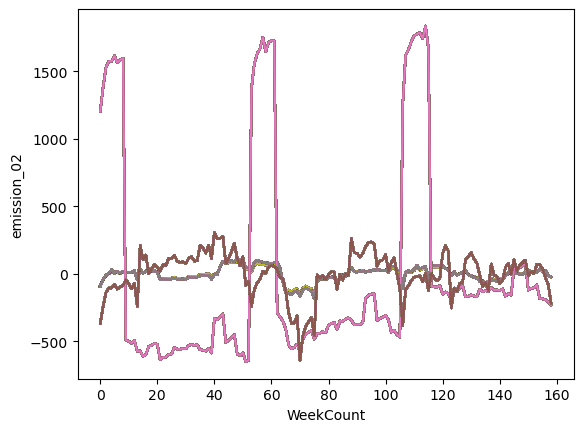

CPU times: total: 9.94 s
Wall time: 10.2 s


In [58]:
%%time

study_number = '03'

quantile = train_from_part_1['emission'].quantile(0.99)

for location in train_from_part_1.loc[train_from_part_1['Location_enc'] > quantile, 'Location']:
    sns.lineplot(data=pd.concat([train[train['Location'] == location], cv[cv['Location'] == location]]), x='WeekCount', y='emission_02')
plt.show()

Let's look at periodograms for our top three emissions locations:

C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
C:\Users\mikej\My Drive\5\Kaggle\CO2-Emissions\functions\plot_periodogram.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1W")


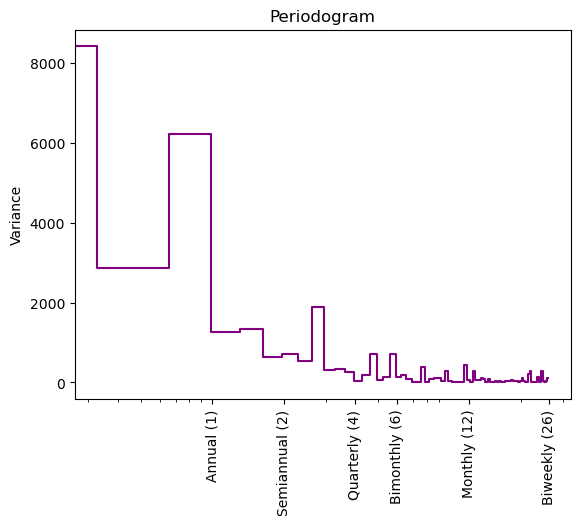

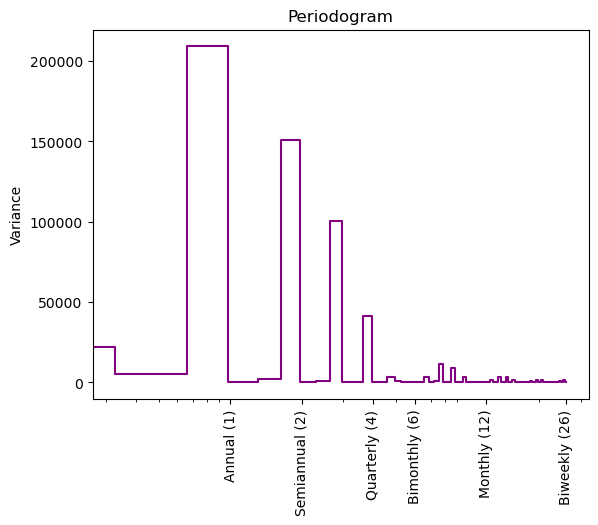

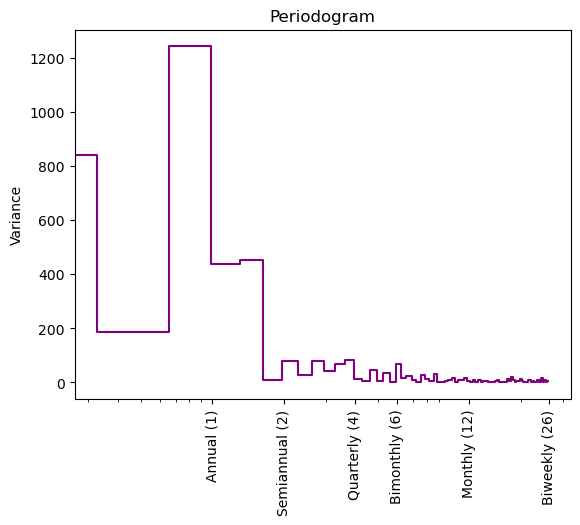

In [59]:
from functions.plot_periodogram import plot_periodogram

for value in top_three_values:
    series = pd.Series(train_from_part_1.loc[train_from_part_1['Location_enc'] == value, 'emission'].values, \
                   index=train_from_part_1.loc[train_from_part_1['Location_enc'] == value, 'date'])
    series.index = series.index.to_period('W')
    plot_periodogram(series)


For the first location, it looks like we need 3 Forier pairs, since Variance drops between Semiannual and Quarterly.

For the second location, we need 4 pairs, and for the 3 location (that is similar to all other locations), we need 2 pairs.


Let's calculate Seasonality for all Locations:

In [60]:
%%time

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# For each location
for location in train['Location'].unique():
    # Create time series
    series = pd.Series(train.loc[train['Location'] == location, 'emission_02'].values, \
                   index=train.loc[train['Location'] == location, 'date'])
    series.index = series.index.to_period('W')
    #Save indices
    old_train_index = train[train['Location'] == location].index
    old_cv_index = cv[cv['Location'] == location].index
    
    
    # sin/cos pairs for annual seasonality
    pairs = 14
    if location == top_three_locations[0]:
        pairs = 12
    elif location == top_three_locations[1]:
        pairs = 10
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    ## Calculate seasonality on the training set
    
    # create features for dates in index
    X = dp.in_sample() 
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, series)
    y_pred = pd.Series(lr.predict(X), index=old_train_index)
    train.loc[old_train_index, 'Seasonality'] = y_pred
    

    # Predict seasonality for the cv set
    X = dp.out_of_sample(steps=cv_weeks)
    y_pred = pd.Series(lr.predict(X), index=old_cv_index)
    cv.loc[old_cv_index, 'Seasonality'] = y_pred


CPU times: total: 54 s
Wall time: 12.8 s


Let's look at seasonality plots for our top three emissions locations:

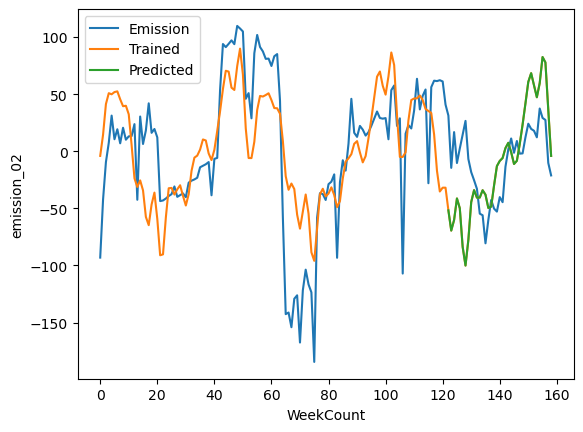

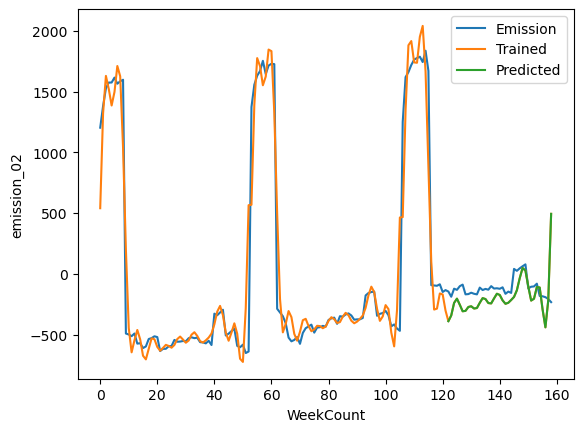

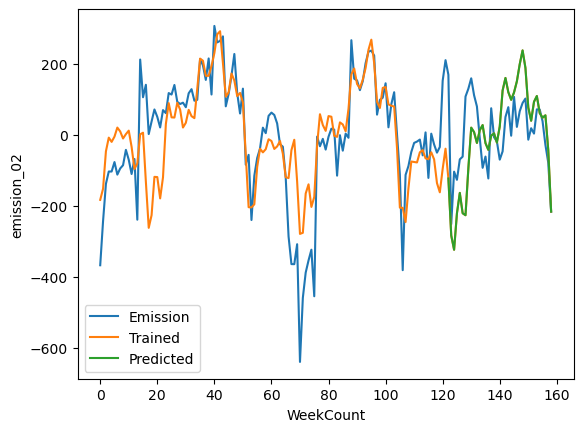

CPU times: total: 1.08 s
Wall time: 563 ms


In [61]:
%%time

for location in top_three_locations:
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                 x='WeekCount', y='emission_02', label='Emission')
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                                  x='WeekCount', y='Seasonality', label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Seasonality', label='Predicted')
    plt.show()


Let's calculate Scores. For this, we'll need add back Trend, that we substracted before:

In [62]:
# Add back substractions:
pred_train = train['Seasonality'] + train['Trend']
pred_cv = cv['Seasonality'] + cv['Trend']

# Calculate scores
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ Seasonality'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN
3,+ Seasonality,17.331707,16.146329,NaN


Great. Now let's prepare data for sumbission:

In [63]:
%%time

# Recalculate Seasonality on the all available data

train_and_cv = pd.concat([train, cv])

lr = LinearRegression(fit_intercept=False)

# For each location
for location in train['Location'].unique():
    # Create time series
    series = pd.Series(train_and_cv.loc[train_and_cv['Location'] == location, 'emission_02'].values, \
                   index=train_and_cv.loc[train_and_cv['Location'] == location, 'date'])
    series.index = series.index.to_period('W')
    #Save indices
    old_train_and_cv_index = train_and_cv[train_and_cv['Location'] == location].index
    old_train_index = train[train['Location'] == location].index
    old_cv_index = cv[cv['Location'] == location].index
    old_test_index = test[test['Location'] == location].index
    
    # sin/cos pairs for annual seasonality
    pairs = 12
    if location == top_three_locations[0]:
        pairs = 14
    elif location == top_three_locations[1]:
        pairs = 10
    fourier = CalendarFourier(freq="A", order=pairs)  
    
    # Set up DeterministicProcess
    dp = DeterministicProcess(index=series.index, constant=True,
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # indicators
        additional_terms=[fourier],  # annual seasonality
        drop=True,                   # drop terms to avoid collinearity
    )
    
    # Recalculate Seasonality on the all available data

    
    # create features for dates in index
    X = dp.in_sample() 
    
    
    lr.fit(X, series)
    y_pred = pd.Series(lr.predict(X), index=old_train_and_cv_index)
    train.loc[old_train_index, 'Seasonality'] = y_pred[: train_weeks]
    cv.loc[old_cv_index, 'Seasonality'] = y_pred[train_weeks :]

    # Predict seasonality for the test set
    X = dp.out_of_sample(steps=test_weeks)
    y_pred = pd.Series(lr.predict(X), index=old_test_index)
    test.loc[old_test_index, 'Seasonality'] = y_pred


CPU times: total: 1min 11s
Wall time: 16.5 s


Let's look at the seasonality examples for our top three Locations:

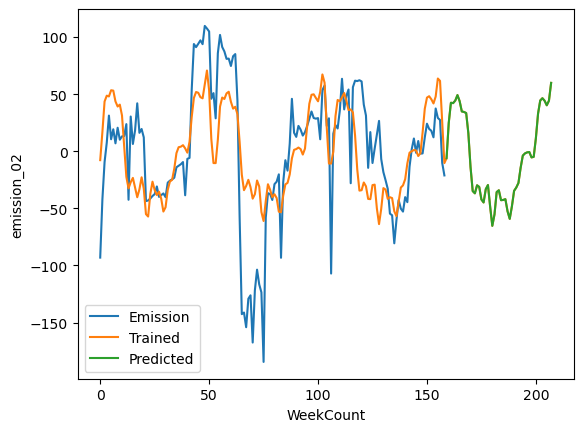

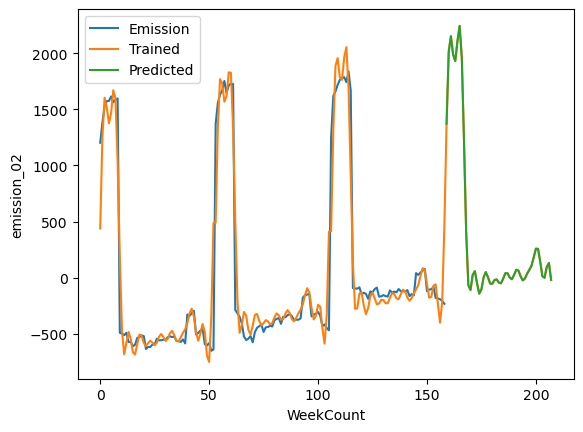

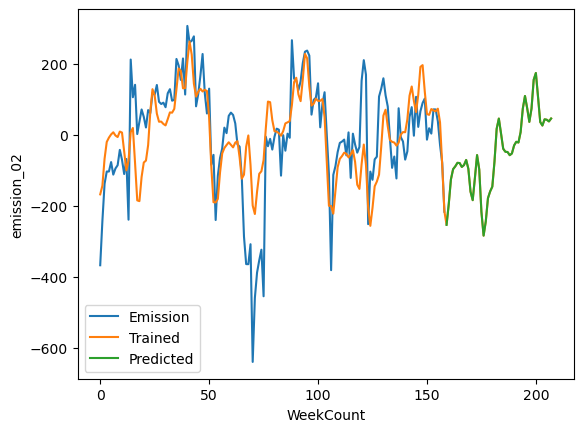

CPU times: total: 1.14 s
Wall time: 646 ms


In [64]:
%%time

# for location in top_three_locations:

#     sns.lineplot(data = train_from_part_1[train_from_part_1['Location'] == location], x='WeekCount', y='emission', label='Emission')
#     sns.lineplot(data = train[train['Location'] == location], x='WeekCount', y='Trend', label='Trained', c='b')
#     sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Trend', label='Trained', c='b')
#     sns.lineplot(data = test[test['Location'] == location], x='WeekCount', y='Trend', label='Predicted')
#     plt.legend()
#     plt.show()


for location in top_three_locations:
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                 x='WeekCount', y='emission_02', label='Emission')
    sns.lineplot(data = pd.concat([train[train['Location'] == location],
                                   cv[cv['Location'] == location],
                                  test[test['Location'] == location]]),
                                  x='WeekCount', y='Seasonality', label='Trained')
    sns.lineplot(data = test[test['Location'] == location], x='WeekCount', y='Seasonality', label='Predicted')
    plt.show()


Let's make a submission and look at the Test RMSE:

In [65]:
pred_test = test['Seasonality'] + test['Trend']

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [26]:
scores_df.loc[int(study_number), 'Test RMSE'] = 30.19904

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN
3,+ Seasonality,17.457597,16.397847,NaN


Let's create the detrended and deseasonalized feature:

In [27]:
for data in [train, cv]:
    data['emission_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality']
    
train.head()

,Location,WeekCount,date,emission,CommonTrend,Trend,emission_02,Seasonality,emission_03
ID_LAT_LON_YEAR_WEEK,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.5129.29,0,2019-01-01,3.750994,50.995863,4.527272,-0.776278,-0.313722,-0.462555
ID_-0.510_29.290_2019_01,-0.5129.29,1,2019-01-08,4.025176,50.833865,4.515137,-0.489960,-0.239301,-0.250659
ID_-0.510_29.290_2019_02,-0.5129.29,2,2019-01-15,4.231381,50.673625,4.503172,-0.271791,-0.077291,-0.194500
ID_-0.510_29.290_2019_03,-0.5129.29,3,2019-01-22,4.305286,50.515145,4.491378,-0.186092,0.016752,-0.202844
ID_-0.510_29.290_2019_04,-0.5129.29,4,2019-01-29,4.347317,50.358424,4.479753,-0.132436,0.032080,-0.164516


## 04. Cycles

Let's explore lags of our time series (the 'top three' Locations). We'll use a few functions by Ryan Holbrook.

C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\mikej\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


CPU times: total: 2.16 s
Wall time: 2.43 s


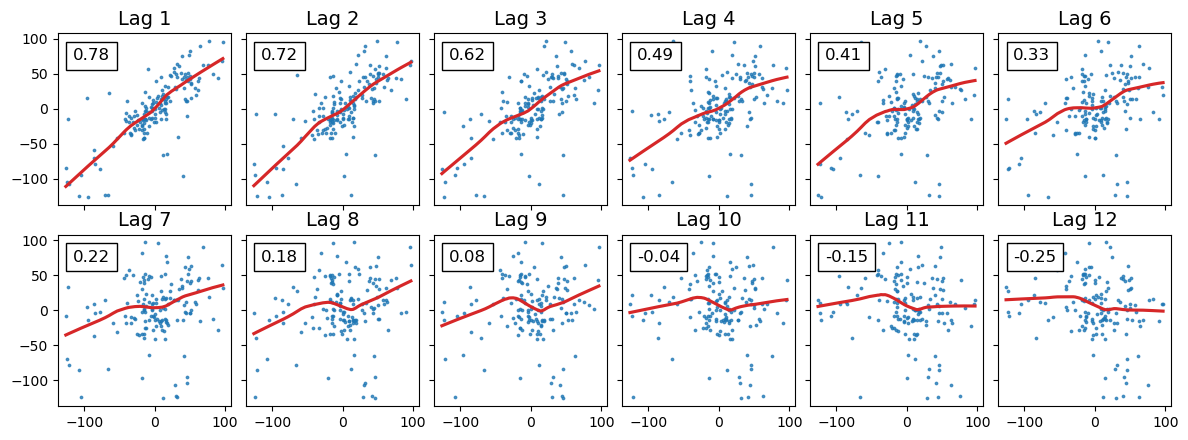

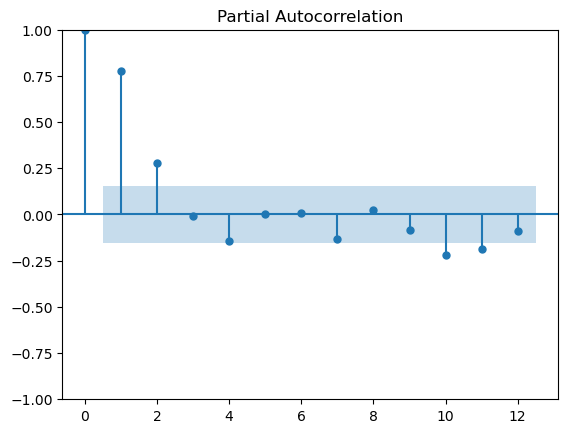

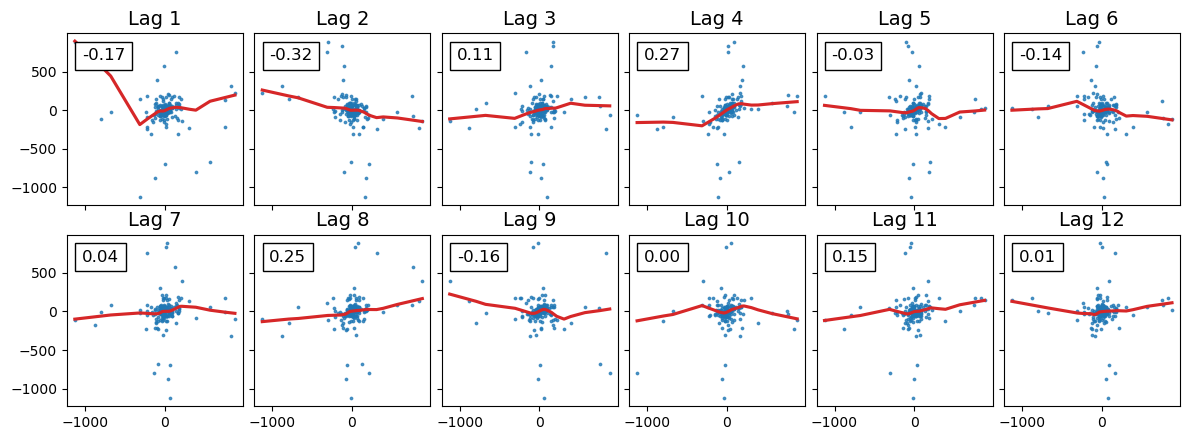

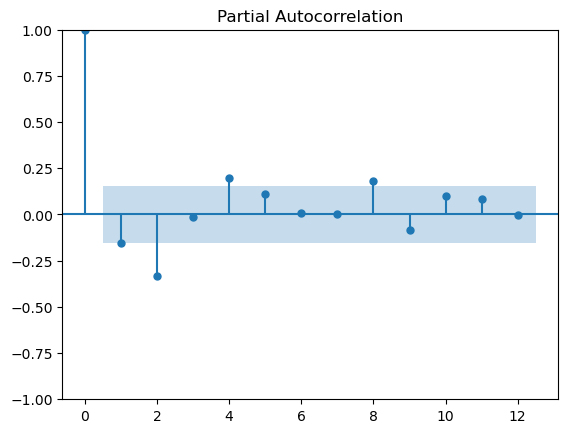

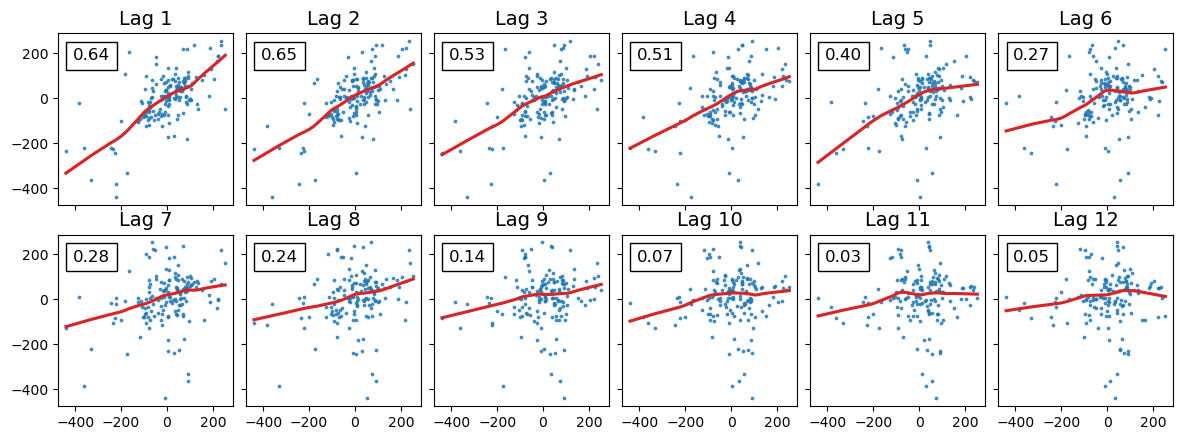

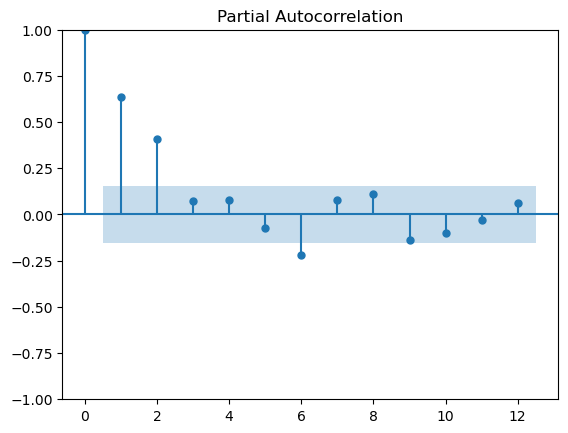

In [28]:
%%time

study_number = '04'

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

LAGS = 6 * 2

train_and_cv = pd.concat([train, cv])

for location in top_three_locations:
    series = pd.Series(train_and_cv.loc[train_and_cv['Location'] == location, 'emission_03'].values, \
                   index=train_and_cv.loc[train_and_cv['Location'] == location, 'WeekCount'])
    _ = plot_lags(series, lags=LAGS, nrows= round(LAGS / 6))
    _ = plot_pacf(series, lags=LAGS)




There are differences between Locations, but all of them suggest at least 1-week cycle. Let's create the corresponding feature:

In [29]:
%%time

# For each location
for location in train['Location'].unique():
    # Calculate lag_1 for training and cv sets
    train_and_cv.loc[train_and_cv['Location'] == location, 'emission_03_lag_1'] = \
            train_and_cv.loc[train_and_cv['Location'] == location, 'emission_03'].shift(1)
    
# Fill a mising lag for the first week with a value for the first week
train_and_cv.loc[train_and_cv['WeekCount'] == 0, 'emission_03_lag_1'] = \
                        train_and_cv.loc[train_and_cv['WeekCount'] == 0, 'emission_03']


# Copy to train and cv sets
train['emission_03_lag_1'] = train_and_cv.loc[train.index, 'emission_03_lag_1']
cv['emission_03_lag_1'] = train_and_cv.loc[cv.index , 'emission_03_lag_1']

cv.tail()

CPU times: total: 3.86 s
Wall time: 4.31 s


,Location,WeekCount,date,emission,CommonTrend,Trend,emission_02,Seasonality,emission_03,emission_03_lag_1
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,
ID_-3.299_30.301_2021_48,-3.29930.301,154,2021-12-03,29.404171,46.771604,29.310005,0.094166,1.439471,-1.345306,-0.312922
ID_-3.299_30.301_2021_49,-3.29930.301,155,2021-12-10,29.186497,46.880501,29.406178,-0.219681,1.322154,-1.541834,-1.345306
ID_-3.299_30.301_2021_50,-3.29930.301,156,2021-12-17,29.131205,46.991157,29.503768,-0.372563,0.529410,-0.901973,-1.541834
ID_-3.299_30.301_2021_51,-3.29930.301,157,2021-12-24,28.125792,47.103572,29.602777,-1.476985,-0.824110,-0.652874,-0.901973
ID_-3.299_30.301_2021_52,-3.29930.301,158,2021-12-31,27.239302,47.217747,29.703204,-2.463902,-1.807673,-0.656228,-0.652874


Now, let's try to predict 'emission_03' based on 'emission_03_lag_1':

In [30]:
%%time

# Instantiate the estimator
model = LinearRegression(fit_intercept=False)

# For each location
for location in train['Location'].unique():
    
    # Save indices
    old_train_index = train[train['Location'] == location].index
    old_cv_index = cv[cv['Location'] == location].index
    
    # Dataframes
    emission_03_lag_1_train = pd.DataFrame(train.loc[old_train_index, 'emission_03_lag_1'])
    emission_03_lag_1_cv = pd.DataFrame(cv.loc[old_cv_index, 'emission_03_lag_1'])
    
    
    # Fit to the training set
    model.fit(emission_03_lag_1_train, train.loc[train['Location'] == location, 'emission_03'])
    
    # Predict for the training and cross-validation sets
    
    train_pred = pd.Series(model.predict(emission_03_lag_1_train), index=old_train_index)
    train.loc[old_train_index, 'Cycles'] = train_pred
    
    cv_pred = pd.Series(model.predict(emission_03_lag_1_cv), index=old_cv_index)
    cv.loc[old_cv_index, 'Cycles'] = cv_pred
    

CPU times: total: 27.4 s
Wall time: 7.6 s


Let's look at the results at our top three Locations:

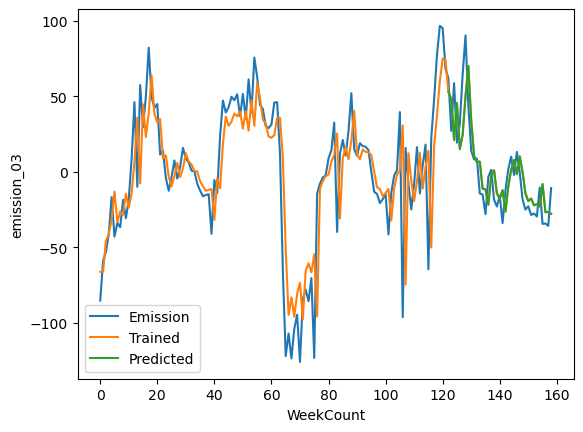

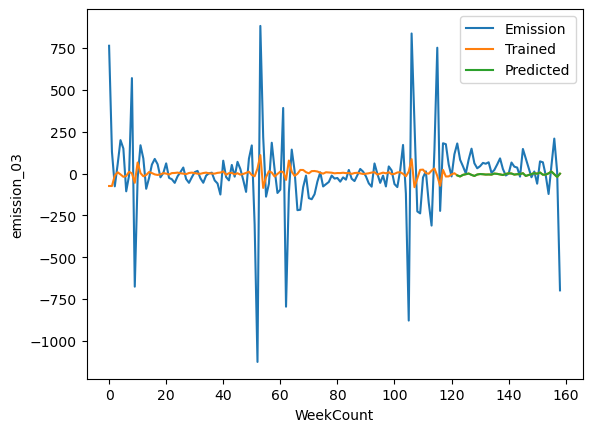

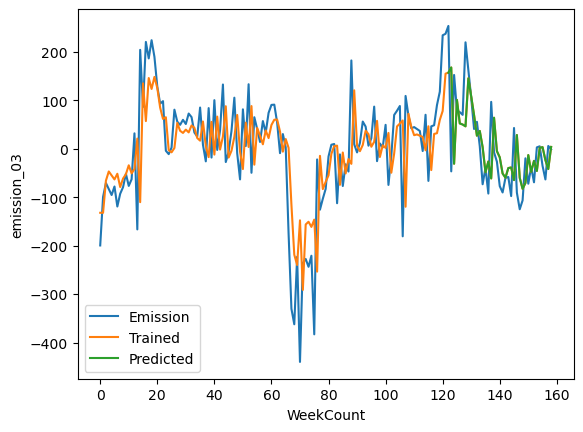

In [31]:
for location in top_three_locations:
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                 x='WeekCount', y='emission_03', label='Emission')
    sns.lineplot(data = pd.concat([train[train['Location'] == location],
                                   cv[cv['Location'] == location],
                                  test[test['Location'] == location]]),
                                  x='WeekCount', y='Cycles', label='Trained')
    sns.lineplot(data = cv[cv['Location'] == location], x='WeekCount', y='Cycles', label='Predicted')
    plt.show()


Let's calculate Scores.

In [32]:
# Add back substractions:
pred_train = train['Cycles'] + train['Seasonality'] + train['Trend']
pred_cv = cv['Cycles'] + cv['Seasonality'] + cv['Trend']

# Calculate scores
score_train = mean_squared_error(train['emission'], pred_train, squared=False)
score_cv = mean_squared_error(cv['emission'], pred_cv, squared=False)


# Write down the scores
scores_df.loc[int(study_number), 'Comment'] = '+ Cycles'
scores_df.loc[int(study_number), 'Train RMSE'] = score_train
scores_df.loc[int(study_number), 'Cross-val RMSE'] = score_cv
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan

scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN
3,+ Seasonality,17.457597,16.397847,NaN
4,+ Cycles,16.237550,11.940636,NaN


Now, we need to forecast. We'll use the Direct strategy. First, we need to recalculate Cycles on the all available data:

In [33]:
%%time

# Recalculate Cycles on the all available data

train_and_cv = pd.concat([train, cv])

# For each location
for location in train['Location'].unique():
    
    # Save indices
    old_train_and_cv_index = train_and_cv[train_and_cv['Location'] == location].index
    old_train_index = train[train['Location'] == location].index
    old_cv_index = cv[cv['Location'] == location].index
    old_test_index = test[test['Location'] == location].index
    
    # Dataframes
    emission_03_lag_1_train_and_cv = pd.DataFrame(train_and_cv.loc[old_train_and_cv_index, 'emission_03_lag_1'])
    emission_03_lag_1_train = pd.DataFrame(train.loc[old_train_index, 'emission_03_lag_1'])
    emission_03_lag_1_cv = pd.DataFrame(cv.loc[old_cv_index, 'emission_03_lag_1'])
    
    
    # Fit to the all available data
    model.fit(emission_03_lag_1_train_and_cv, train_and_cv.loc[train_and_cv['Location'] == location, 'emission_03'])
    
    # Predict for the training and cross-validation sets
    
    train_pred = pd.Series(model.predict(emission_03_lag_1_train), index=old_train_index)
    train.loc[old_train_index, 'Cycles'] = train_pred
    
    cv_pred = pd.Series(model.predict(emission_03_lag_1_cv), index=old_cv_index)
    cv.loc[old_cv_index, 'Cycles'] = cv_pred
    

CPU times: total: 43.5 s
Wall time: 11.8 s


Now, we'll apply the Direct strategy to create the forecast. For the sake of runtime, we'll do in a separate file: ['functions/cycles_forecast.py'] (functions/cycles_forecast.py).

In [34]:
train.to_csv('new_datasets/train_02_04.csv')
cv.to_csv('new_datasets/cv_02_04.csv') 
test.to_csv('new_datasets/test_02_04.csv') 

After calculation, let's load files back:

In [35]:
train = pd.read_csv('new_datasets/train_02_04_result.csv', index_col='ID_LAT_LON_YEAR_WEEK')
cv = pd.read_csv('new_datasets/cv_02_04_result.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test = pd.read_csv('new_datasets/test_02_04_result.csv', index_col='ID_LAT_LON_YEAR_WEEK')

test['Cycles_forecast'] = test['Cycles']
test = test.drop('Cycles', axis=1)

Let's examine the results:

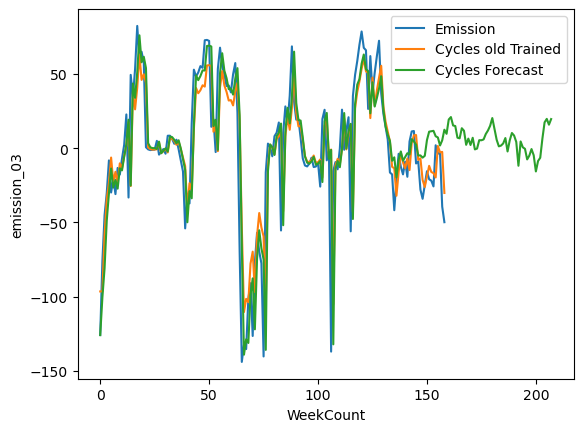

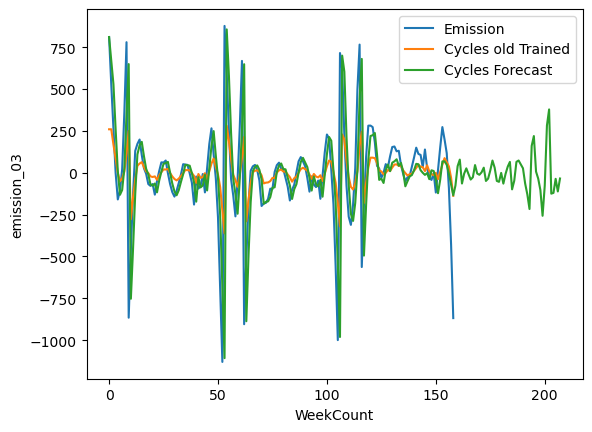

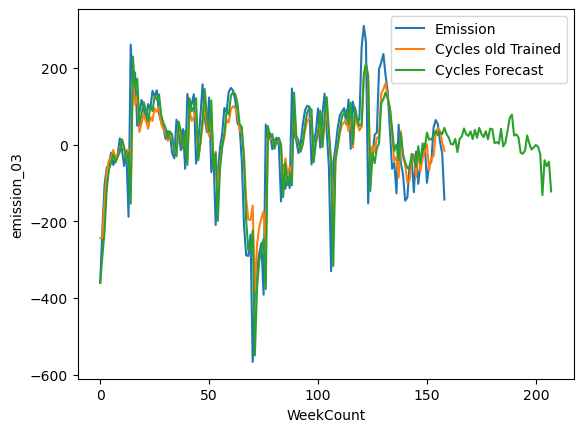

In [36]:
for location in top_three_locations:
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                 x='WeekCount', y='emission_03', label='Emission')
    sns.lineplot(data = pd.concat([train[train['Location'] == location],
                                   cv[cv['Location'] == location],
                                  test[test['Location'] == location]]),
                                  x='WeekCount', y='Cycles', label='Cycles old Trained')
    sns.lineplot(data = pd.concat([train[train['Location'] == location],
                                   cv[cv['Location'] == location],
                                  test[test['Location'] == location]]),
                                  x='WeekCount', y='Cycles_forecast', label='Cycles Forecast')
    plt.show()


Let's make a submission and look at the Test RMSE:

In [37]:
pred_test = test['Cycles_forecast'] + test['Seasonality'] + test['Trend']

# Create a submission file (median emissions calculated on the whole available data)
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_from_part_1.index, \
                           'emission': pred_test})

submission.to_csv('submissions/submission_2_' + study_number + '.csv', index=False)

In [38]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train RMSE,Cross-val RMSE,Test RMSE
0,Just Median,150.370895,144.132480,175.20974
1,CommonTrend,150.222710,143.983918,NaN
2,Trend,47.029818,30.359811,NaN
3,+ Seasonality,17.457597,16.397847,NaN
4,+ Cycles,16.237550,11.940636,NaN


Let's create 'emission_04' and look at our three top Locations:

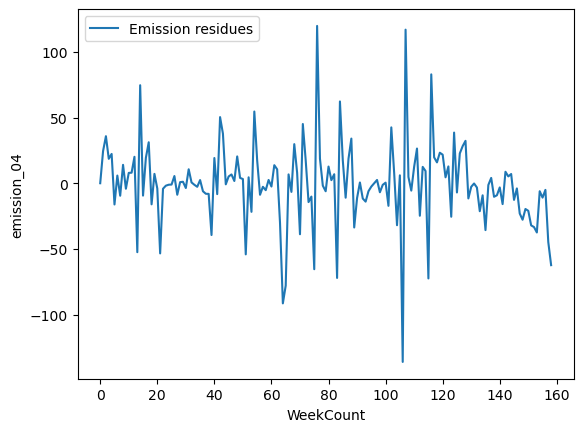

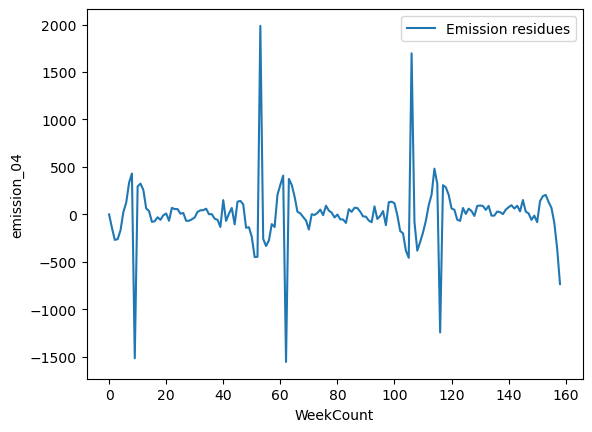

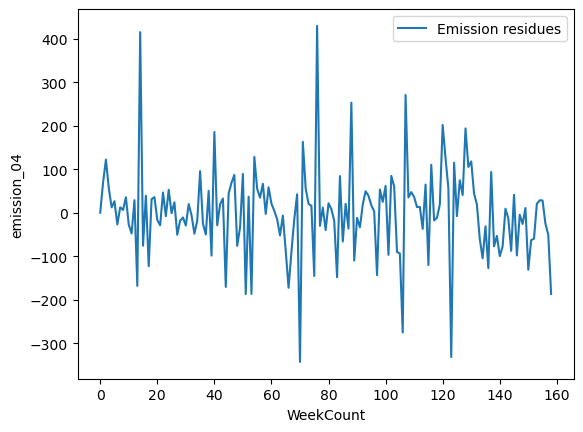

In [39]:
for data in [train, cv]:
    data['emission_' + study_number] = data['emission'] - data['Trend'] - data['Seasonality'] - data['Cycles_forecast']
    
for location in top_three_locations:
    sns.lineplot(data = pd.concat([train[train['Location'] == location],cv[cv['Location'] == location]]),
                 x='WeekCount', y='emission_04', label='Emission residues')
    plt.show()


There is still some uncatched seasonality in the second location, but it's depends on week of the year and we'll catch it later.

For now, let's proceed to Part 3: ['CO2 Emissions 3.ipynb'](CO2 Emissions 3.ipynb).

In [40]:
train.to_csv('new_datasets/train_from_part_2.csv')
cv.to_csv('new_datasets/cv_from_part_2.csv')
test.to_csv('new_datasets/test_from_part_2.csv')
scores_df.to_csv('scores_df_2.csv')